# Setting

## Library

In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import random
import os
from tqdm.notebook import tqdm

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score # 정확도
from sklearn.metrics import precision_score # 정밀도
from sklearn.metrics import recall_score # 재현율
from sklearn.metrics import f1_score # F1-Score
from sklearn.metrics import confusion_matrix

In [6]:
import warnings
warnings.filterwarnings('ignore')

## Seed

In [7]:
def my_seed_everywhere(seed):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    print(f'고정된 Seed : {seed}')

In [8]:
my_seed_everywhere(42)

고정된 Seed : 42


# Data Set

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [134]:
path_file = '/content/drive/MyDrive/UNIST/AICP/data/dynmom_dat.csv'

df = pd.read_csv(path_file)

# Preprocessing

In [135]:
def preprocessing(data, used=None):
  # 'DATE'를 칼럼 대신 인덱스로 사용
  data.index = data['DATE']
  data = data.drop(columns='DATE')
  print("'DATE'를 칼럼 대신 인덱스로 사용")

  # 결측치 제거 및 모델 학습에 불필요한 칼럼 제거
  data = data.dropna()
  data = data.drop(columns=['winner', 'loser', 'form_date'])
  print("결측치 제거 및 모델 학습에 불필요한 칼럼 제거 ('winner', 'loser', 'form_date')")

  if used != None:
    used += ['wml']
    D = ', '.join(used)
    data = data[used]
    print(f"훈련에 사용되는 변수 들 : {D}")

  return data

In [136]:
dynmom = preprocessing(df,
                       used=['mvol_t_1', 'mvol_t_2', 'mvol_t_3', 'mvol_t_4' , 'mvol_t_5', 'mvol_t_6',
                             'cum_winner_t_2_4', 'cum_winner_t_5_8', 'cum_winner_t_9_12',
                             'cum_loser_t_2_4', 'cum_loser_t_5_8', 'cum_loser_t_9_12'])

'DATE'를 칼럼 대신 인덱스로 사용
결측치 제거 및 모델 학습에 불필요한 칼럼 제거 ('winner', 'loser', 'form_date')
훈련에 사용되는 변수 들 : mvol_t_1, mvol_t_2, mvol_t_3, mvol_t_4, mvol_t_5, mvol_t_6, cum_winner_t_2_4, cum_winner_t_5_8, cum_winner_t_9_12, cum_loser_t_2_4, cum_loser_t_5_8, cum_loser_t_9_12, wml


# Modeling

In [217]:
def define_pos_wml(df, purpose):

  if purpose == 'train':
    cond_wml = (df['wml']>=0.0)
    df.loc[cond_wml, 'pos_wml'] = 0
    df.loc[~cond_wml, 'pos_wml'] = 1

  if purpose == 'test':
    cond_wml = (df['wml']>=0.0)
    df.loc[cond_wml, 'pos_wml'] = 0
    df.loc[~cond_wml, 'pos_wml'] = 1


  return df

In [218]:
def dynamic_momentum(wml, dynamic_leverage):
  dy_mom = np.multiply(wml, dynamic_leverage)
  return dy_mom

In [219]:
def sharpe_ratio(dynamic_momentum):
  SR = (np.mean(dynamic_momentum)/np.std(dynamic_momentum))*math.sqrt(12)
  return SR

In [220]:
def cumulative_return(dynamic_momentum):
  CR = (1 + dynamic_momentum).cumprod() - 1
  CR = CR[-1]
  return CR

In [221]:
def probability_nomal(X):
  prob = []
  for i in X:
    prob.append(i[0])
  return prob

In [222]:
def Roling_Windows(data, window_size, validation_size, method, model):

  # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
  result_train = {
      'TRAIN_START_DATE':[], # 훈련 데이터 시작 지점
      'TRAIN_END_DATE':[], # 훈련 데이터 마지막 지점
      'Sharpe_Ratio':[],
      'Cumulative_Return':[],
      'F1_Score':[]
  }

  result_val = {
      'VAL_START_DATE':[], # 훈련 데이터 시작 지점
      'VAL_END_DATE':[], # 훈련 데이터 마지막 지점
      'Sharpe_Ratio':[],
      'Cumulative_Return':[],
      'F1_Score':[]
  }

  result_test = {
      'TEST_DATE':[], # 테스트 데이터 지점
      'wml':[], # wml 값
      'dynamic_momentum':[], # 다이나믹 모멘텀 값
      'Actual_POS_WML':[], # 실제 Target 값 (0 or 1)
      'dynamic_leverage':[], # 추론된 Target 확률값
      'static_leverage':[], # 추론된 Target 값 (0 or 1)
  }

  # 모델 학습이 종료되는 지점 설정
  end = data.shape[0] - window_size

  print('*'*50)
  print('설정된 Model의 하이퍼파리미터 : \n')
  for p, v in zip(model.get_params(deep=True).keys(), model.get_params(deep=True).values()):
    print(f'   {p} : {v}')
  print()
  print('*'*50)

  for i in tqdm(range(end-validation_size)):

    # 모델 학습 중지
    if i == end:
      print('Prediction using machine learning has ended.')
      break

    # Rolling Fixed Window
    if method == 'Fixed':
      MODEL = model
      train = data.iloc[0+i:window_size+i]
      TRAIN = define_pos_wml(train, purpose='train')

      val = data.iloc[window_size+i:window_size+validation_size+i]
      VAL = define_pos_wml(val, purpose='train')

    # Rolling Expanding Window
    if method == 'Expanding':
      MODEL = model
      train = data.iloc[0:window_size+i]
      TRAIN = define_pos_wml(train, purpose='train')

      val = data.iloc[window_size+i:window_size+validation_size+i]
      VAL = define_pos_wml(val, purpose='train')

    # 테스트 데이터 설정
    test = data.iloc[[window_size+validation_size+i]]
    TEST = define_pos_wml(test, purpose='test')

    # Features와 Target 구분
    X_train = TRAIN.drop(columns=['pos_wml', 'wml'])
    y_train = TRAIN['pos_wml']

    X_val = VAL.drop(columns=['pos_wml', 'wml'])
    y_val = VAL['pos_wml']

    X_test = TEST.drop(columns=['pos_wml', 'wml'])
    y_test = TEST['pos_wml']

    wml_train = list(train['wml'])
    wml_val = list(val['wml'])
    wml_test = list(test['wml'])

    # 모델 학습 및 추론
    MODEL.fit(X_train, y_train)

    pred_train = MODEL.predict(X_train)
    prob_train = MODEL.predict_proba(X_train)
    prob_train = probability_nomal(prob_train)

    pred_val = MODEL.predict(X_val)
    prob_val = MODEL.predict_proba(X_val)
    prob_val = probability_nomal(prob_val)

    pred_test = MODEL.predict(X_test)
    prob_test = MODEL.predict_proba(X_test)


    # 학습 및 테스트 데이터 정보
    result_train['TRAIN_START_DATE'].append(str(train.index[0]))
    result_train['TRAIN_END_DATE'].append(str(train.index[-1]))
    train_mom = dynamic_momentum(wml_train, prob_train)
    result_train['Sharpe_Ratio'].append(sharpe_ratio(train_mom))
    result_train['Cumulative_Return'].append(cumulative_return(train_mom))
    result_train['F1_Score'].append(f1_score(y_train, pred_train))

    result_val['VAL_START_DATE'].append(str(val.index[0]))
    result_val['VAL_END_DATE'].append(str(val.index[-1]))
    val_mom = dynamic_momentum(wml_val, prob_val)
    result_val['Sharpe_Ratio'].append(sharpe_ratio(val_mom))
    result_val['Cumulative_Return'].append(cumulative_return(val_mom))
    result_val['F1_Score'].append(f1_score(y_val, pred_val))


    result_test['TEST_DATE'].append(str(test.index[0]))
    result_test['wml'].append(wml_test[0])
    test_dynamic_momentum = prob_test[0][0] * wml_test[0]
    result_test['dynamic_momentum'].append(test_dynamic_momentum)
    result_test['Actual_POS_WML'].append(list(y_test)[0])
    result_test['static_leverage'].append(pred_test[0])
    result_test['dynamic_leverage'].append(prob_test[0][0])

    RESULT_TRAIN = pd.DataFrame(result_train)
    RESULT_VAL = pd.DataFrame(result_val)
    RESULT_TEST = pd.DataFrame(result_test)

    RESULT_TEST = RESULT_TEST.set_index('TEST_DATE')

  return RESULT_TRAIN, RESULT_VAL, RESULT_TEST

In [223]:
def statistic_information(data, col, data_set=None):
  statistic = data[[col]].describe().T
  statistic['var'] = data[col].var()
  statistic['1%'] = data[col].quantile(0.01)
  statistic['99%'] = data[col].quantile(0.99)

  statistic = statistic[['count', 'mean', 'var', 'std',
                         'min', '1%', '25%', '50%',
                         '75%',  '99%', 'max']]
  if data_set != None:
    statistic.index = [data_set+'_'+col]
  else:
    pass

  return statistic

In [224]:
def train_vs_val(train, val):
  plt.figure(figsize=(15, 5))
  plt.title('Line Plot of Sharpe Ratio')
  sns.lineplot(data=train, x=train.index, y='Sharpe_Ratio', marker='o', markersize=0.5 ,linewidth=2, label='train')
  sns.lineplot(data=val, x=val.index, y='Sharpe_Ratio', marker='o', markersize=0.5 ,linewidth=2, label='val')
  plt.show()
  print()
  TRAIN = statistic_information(train, 'Sharpe_Ratio', data_set='TRAIN')
  VAL = statistic_information(val, 'Sharpe_Ratio', data_set='VAL')
  display(TRAIN,VAL)
  print()

  plt.figure(figsize=(15, 5))
  plt.title('Line Plot of Cumulative Return')
  sns.lineplot(data=train, x=train.index, y='Cumulative_Return', marker='o', markersize=0.5 ,linewidth=2, label='train')
  sns.lineplot(data=val, x=val.index, y='Cumulative_Return', marker='o', markersize=0.5 ,linewidth=2, label='val')
  plt.show()
  print()
  TRAIN = statistic_information(train, 'Cumulative_Return', data_set='TRAIN')
  VAL = statistic_information(val, 'Cumulative_Return', data_set='VAL')
  display(TRAIN,VAL)
  print()

  plt.figure(figsize=(15, 5))
  plt.title('Line Plot of F1-Score')
  sns.lineplot(data=train, x=train.index, y='F1_Score', marker='o', markersize=0.5 ,linewidth=2, label='train')
  sns.lineplot(data=val, x=val.index, y='F1_Score', marker='o', markersize=0.5 ,linewidth=2, label='val')
  plt.show()
  TRAIN = statistic_information(train, 'F1_Score', data_set='TRAIN')
  VAL = statistic_information(val, 'F1_Score', data_set='VAL')
  display(TRAIN,VAL)
  print()


In [225]:
def cum_return_sharpe_ratio(data, dynamic=True):

  if dynamic == True:
    weight = 'dynamic_leverage'
  else:
    weight = 'static_leverage'

  # 머신러닝 적용되지 않은 경우 Sharpe Ratio
  w_S = (data['wml'].mean()/data['wml'].std()) * math.sqrt(12)
  print('ORG Sharpe Ratio : {}'.format(w_S))

  # 머신러닝 적용된 경우 Sharpe Ratio
  S = (data['dynamic_momentum'].mean()/data['dynamic_momentum'].std())*math.sqrt(12)
  print('ML Sharpe Ratio : {}\n'.format(S))

  # 머신러닝 적용된 경우 누적 수익률
  data['cum_return'] = (1 + data.dynamic_momentum).cumprod() - 1

  print('\n최근 누적 수익률\n')
  latly_10 = data[['cum_return']].sort_index(ascending=False).head(5)
  for i, r in zip(latly_10.index, latly_10['cum_return']):
    i = str(i)
    print('  {}년-{}월 -> {:0.2f}'.format(i[:4], i[4:6], r))

  print('\n누적 수익률 가장 높았던 순간 Top 10\n')
  top_10 = data[['cum_return']].sort_values(by='cum_return', ascending=False).head(10)
  rank = 1
  for i, r in zip(top_10.index, top_10['cum_return']):
    i = str(i)
    print('  {}등 : {}년-{}월 -> {:0.2f}'.format(rank, i[:4], i[4:6], r))
    rank += 1
  print()

  # 머신러닝 적용되지 않은 경우 누적 수익률
  without_machine = pd.DataFrame(data['wml'])
  without_machine['wml'] = (1 + without_machine.wml).cumprod() - 1
  without_machine.columns = ['cum_return']

  # 머신러닝 여부에 따른 누적 수익률 비교
  plt.figure(figsize=(15, 5))
  plt.title('Comparing Cumulative Returns with and without Machine Learning')
  sns.lineplot(data=data, x=data.index, y=data['cum_return'], label='With_ML', color='darkgreen', lw=3)
  sns.lineplot(data=without_machine, x=without_machine.index, y=without_machine['cum_return'], label='Original', color='gray', lw=3)
  plt.xticks([data.index[i] for i in range(0,len(data.index), 12)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=5,
                  width=5)

  plt.show()

In [271]:
def plot_predict_result(data):
  print('\nPerformance results of the model\n')

  # Confusion Matrix & etc
  print(classification_report(data['Actual_POS_WML'], data['static_leverage']))

  # Accuracy, Precision, Recall, F1 Score
  accuracy = accuracy_score(data['Actual_POS_WML'], data['static_leverage'])
  precision = precision_score(data['Actual_POS_WML'], data['static_leverage'])
  recall = recall_score(data['Actual_POS_WML'], data['static_leverage'])
  F1_score = f1_score(data['Actual_POS_WML'], data['static_leverage'])

  print(f'\naccuracy : {accuracy}')
  print(f'\nprecision : {precision}')
  print(f'\nrecall : {recall}')
  print(f'\nF1-Score : {F1_score}\n')

  # Visualization Confusion Matrix
  confusion = confusion_matrix(data['Actual_POS_WML'], data['static_leverage'])
  sns.heatmap(confusion, annot=True, fmt='g')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.title(f'Confusion Matrix')

  plt.show()

  # ACTUAL = PRED = 1
  cond = (data['Actual_POS_WML'] == 1) & (data['static_leverage'] == 1)
  cond_data = data.loc[cond]
  print('\nACTUAL = PRED = 1\n')
  plt.figure(figsize=(15, 5))
  plt.title('WML & Dynamic Leverage in ACTUAL = PRED = 1')
  sns.lineplot(data=cond_data,
              x=cond_data.index,
              y='wml',
              label='wml')
  sns.lineplot(data=cond_data,
              x=cond_data.index,
              y='dynamic_leverage',
              label='dynamic_leverage')
  plt.xticks([cond_data.index[i] for i in range(0,len(cond_data.index), 12)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=5,
                  width=5)
  plt.show()
  info = statistic_information(cond_data, 'wml')
  display(info)
  info = statistic_information(cond_data, 'dynamic_leverage')
  display(info)

  print()
  print('-'*80)
  print()

  # ACTUAL = PRED = 0
  cond = (data['Actual_POS_WML'] == 0) & (data['static_leverage'] == 0)
  cond_data = data.loc[cond]
  print('\nACTUAL = PRED = 0\n')
  plt.figure(figsize=(15, 5))
  plt.title('WML & Dynamic Leverage in ACTUAL = PRED = 0')
  sns.lineplot(data=cond_data,
              x=cond_data.index,
              y='wml',
              label='wml')
  sns.lineplot(data=cond_data,
              x=cond_data.index,
              y='dynamic_leverage',
              label='dynamic_leverage')
  plt.xticks([cond_data.index[i] for i in range(0,len(cond_data.index), 12)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=5,
                  width=5)
  plt.show()
  info = statistic_information(cond_data, 'wml')
  display(info)
  info = statistic_information(cond_data, 'dynamic_leverage')
  display(info)

  print()
  print('-'*80)
  print()

  # ACTUAL = 0 & PRED = 1
  cond = (data['Actual_POS_WML'] == 0) & (data['static_leverage'] == 1)
  cond_data = data.loc[cond]
  print('\nACTUAL = 0 &  PRED = 1\n')
  plt.figure(figsize=(15, 5))
  plt.title('WML & Dynamic Leverage in ACTUAL = 0 & PRED = 1')
  sns.lineplot(data=cond_data,
              x=cond_data.index,
              y='wml',
              label='wml')
  sns.lineplot(data=cond_data,
              x=cond_data.index,
              y='dynamic_leverage',
              label='dynamic_leverage')
  plt.xticks([cond_data.index[i] for i in range(0,len(cond_data.index), 12)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=5,
                  width=5)
  plt.show()
  info = statistic_information(cond_data, 'wml')
  display(info)
  info = statistic_information(cond_data, 'dynamic_leverage')
  display(info)

  print()
  print('-'*80)
  print()

  # ACTUAL = 1 & PRED = 0
  cond = (data['Actual_POS_WML'] == 1) & (data['static_leverage'] == 0)
  cond_data = data.loc[cond]
  print('\nACTUAL = 1 &  PRED = 0\n')
  plt.figure(figsize=(15, 5))
  plt.title('WML & Dynamic Leverage in ACTUAL = 1 & PRED = 0')
  sns.lineplot(data=cond_data,
              x=cond_data.index,
              y='wml',
              label='wml')
  sns.lineplot(data=cond_data,
              x=cond_data.index,
              y='dynamic_leverage',
              label='dynamic_leverage')
  plt.xticks([cond_data.index[i] for i in range(0,len(cond_data.index), 12)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=5,
                  width=5)
  plt.show()
  info = statistic_information(cond_data, 'wml')
  display(info)
  info = statistic_information(cond_data, 'dynamic_leverage')
  display(info)

## Random Forest

In [227]:
RDF_Param={}
RDF = RandomForestClassifier(**RDF_Param, random_state=42)

In [229]:
RDF_TRAIN, RDF_VAL, RDF_TEST = Roling_Windows(data=dynmom, # 사용할 데이터
                                              window_size=120, # window size (훈련 데이터 셋 크기)
                                              validation_size=120, # 검증 데이터 셋 크기
                                              method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                              model=RDF)

**************************************************
설정된 Model의 하이퍼파리미터 : 

   bootstrap : True
   ccp_alpha : 0.0
   class_weight : None
   criterion : gini
   max_depth : None
   max_features : sqrt
   max_leaf_nodes : None
   max_samples : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_jobs : None
   oob_score : False
   random_state : 42
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]

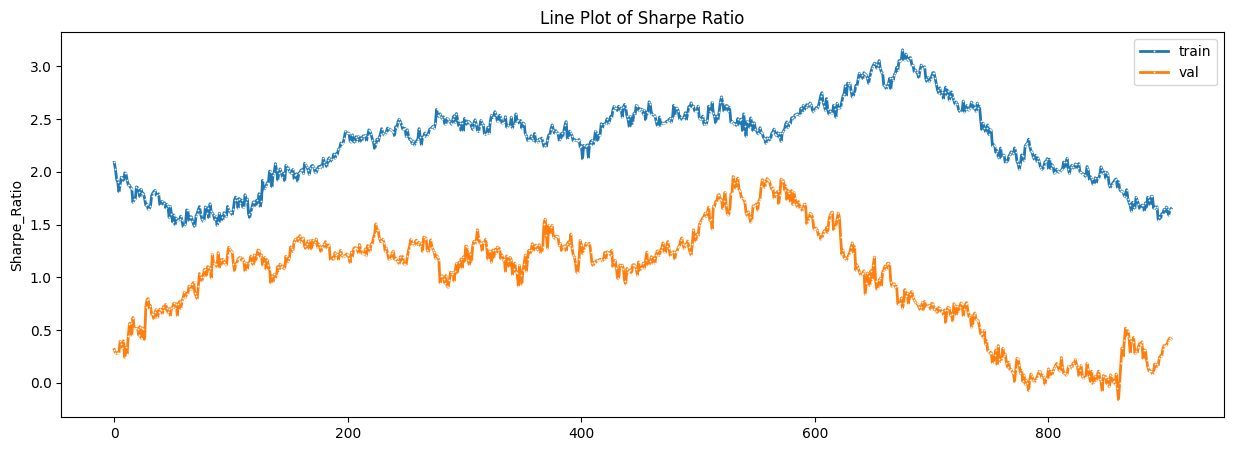

count      mean       var       std       min        1%  \
TRAIN_Sharpe_Ratio  906.0  2.277026  0.146149  0.382295  1.478985  1.532468   

                         25%      50%      75%       99%       max  
TRAIN_Sharpe_Ratio  1.996117  2.35573  2.53431  3.056052  3.158513

count      mean      var      std       min       1%  \
VAL_Sharpe_Ratio  906.0  0.990397  0.24234  0.49228 -0.161812 -0.00896   

                       25%       50%       75%       99%       max  
VAL_Sharpe_Ratio  0.692044  1.135616  1.297809  1.912363  1.956182

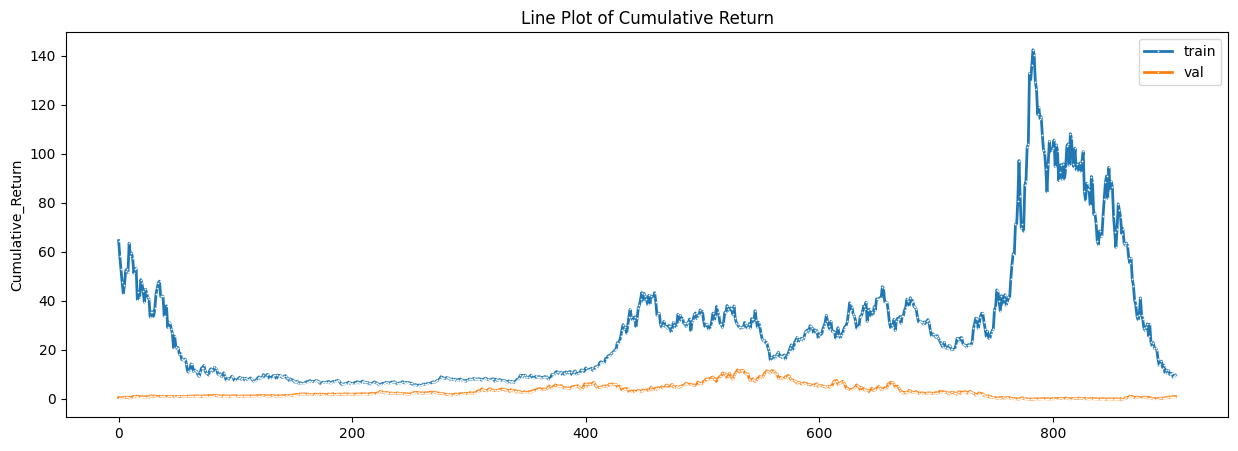

count       mean         var        std       min  \
TRAIN_Cumulative_Return  906.0  28.473019  666.753374  25.821568  5.252025   

                               1%       25%        50%        75%         99%  \
TRAIN_Cumulative_Return  5.721244  8.449973  23.498523  34.953577  115.142098   

                                max  
TRAIN_Cumulative_Return  142.513844

count      mean       var      std       min        1%  \
VAL_Cumulative_Return  906.0  2.988928  7.052635  2.65568 -0.446649 -0.188219   

                            25%       50%       75%        99%        max  
VAL_Cumulative_Return  1.023118  2.254749  4.482996  11.199567  11.766797

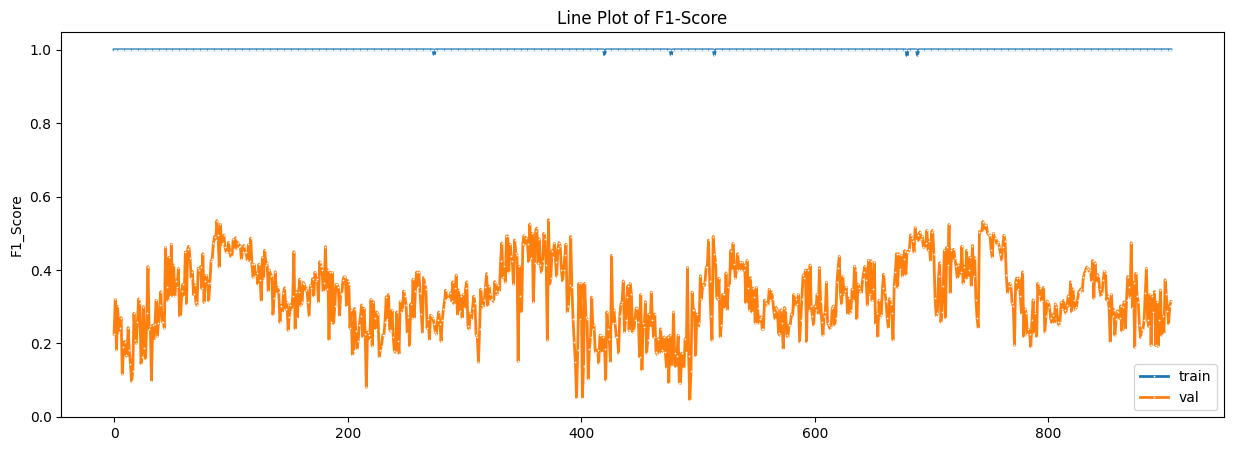

count      mean       var       std       min   1%  25%  50%  \
TRAIN_F1_Score  906.0  0.999904  0.000001  0.001179  0.983607  1.0  1.0  1.0   

                75%  99%  max  
TRAIN_F1_Score  1.0  1.0  1.0

count      mean       var      std       min        1%  \
VAL_F1_Score  906.0  0.327419  0.008776  0.09368  0.046512  0.100128   

                   25%       50%       75%       99%       max  
VAL_F1_Score  0.264151  0.324662  0.394737  0.514026  0.537313

In [272]:
train_vs_val(RDF_TRAIN, RDF_VAL)

ORG Sharpe Ratio : 0.7293406994683723
ML Sharpe Ratio : 0.8785166536609378


최근 누적 수익률

  2022년-12월 -> 8103.42
  2022년-11월 -> 7713.43
  2022년-10월 -> 7546.96
  2022년-09월 -> 7105.81
  2022년-08월 -> 6793.48

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 8103.42
  2등 : 2022년-11월 -> 7713.43
  3등 : 2022년-10월 -> 7546.96
  4등 : 2022년-09월 -> 7105.81
  5등 : 2022년-07월 -> 6892.92
  6등 : 2022년-08월 -> 6793.48
  7등 : 2022년-06월 -> 6708.16
  8등 : 2020년-09월 -> 6703.62
  9등 : 2020년-10월 -> 6688.38
  10등 : 2020년-08월 -> 6667.61



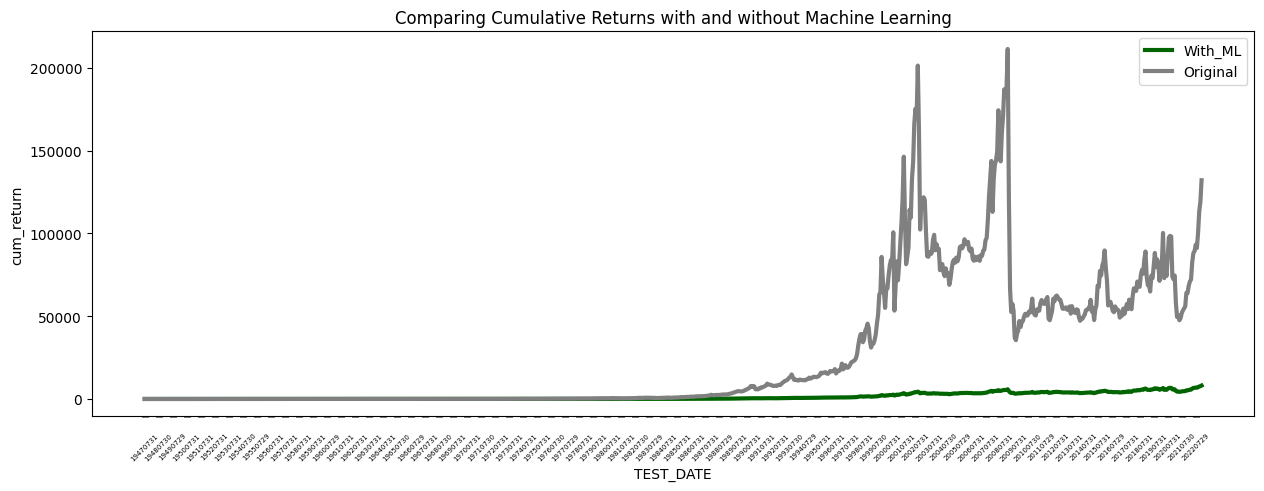

In [273]:
cum_return_sharpe_ratio(RDF_TEST)


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.67      0.74      0.70       590
         1.0       0.39      0.31      0.35       316

    accuracy                           0.59       906
   macro avg       0.53      0.53      0.53       906
weighted avg       0.57      0.59      0.58       906


accuracy : 0.5916114790286976

precision : 0.39285714285714285

recall : 0.31329113924050633

F1-Score : 0.3485915492957746



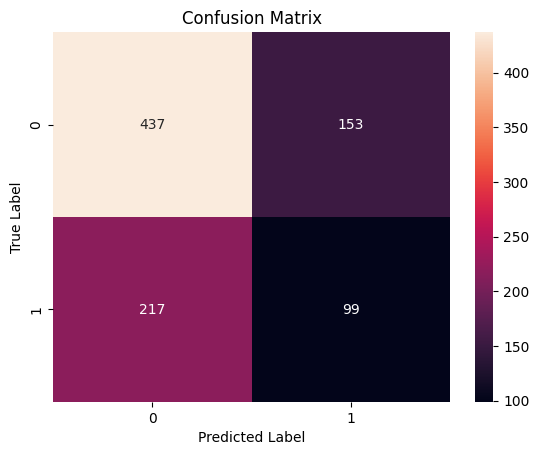


ACTUAL = PRED = 1



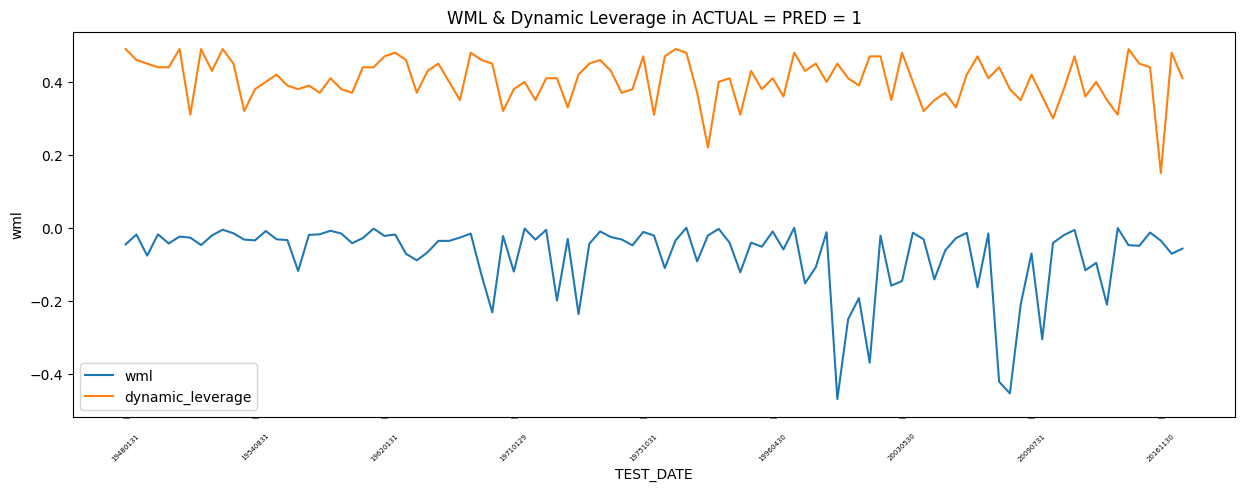

count      mean       var       std       min       1%       25%  \
wml   99.0 -0.075823  0.009521  0.097578 -0.469903 -0.45466 -0.094365   

          50%       75%       99%       max  
wml -0.035448 -0.018668 -0.000182 -0.000132

count      mean       var       std   min      1%   25%  \
dynamic_leverage   99.0  0.406465  0.003705  0.060866  0.15  0.2186  0.37   

                   50%   75%   99%   max  
dynamic_leverage  0.41  0.45  0.49  0.49


--------------------------------------------------------------------------------


ACTUAL = PRED = 0



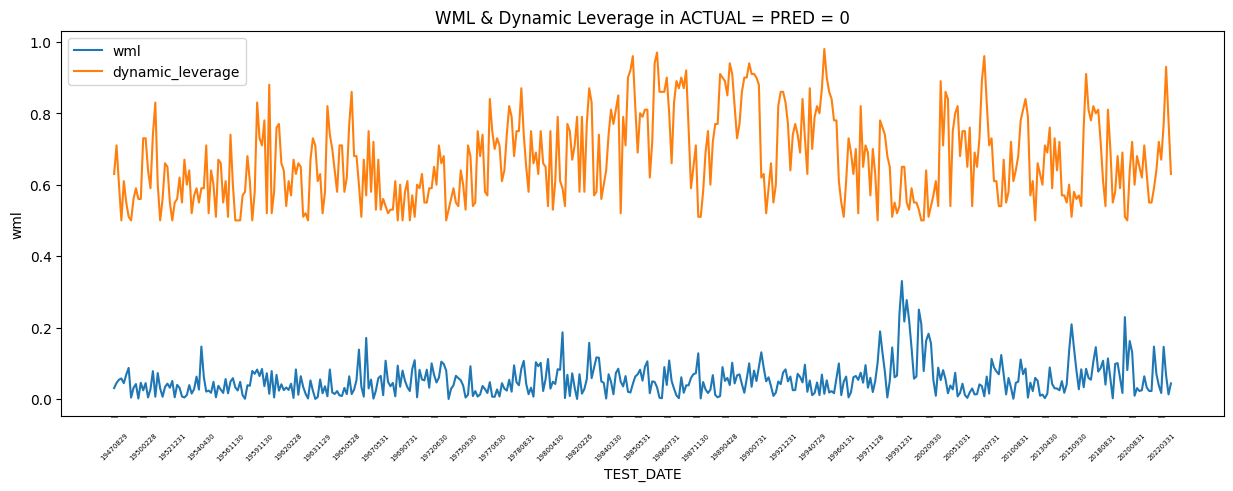

count      mean       var       std       min        1%       25%  \
wml  437.0  0.053636  0.002129  0.046137  0.000007  0.000775  0.021888   

          50%       75%       99%       max  
wml  0.045364  0.070552  0.225487  0.330163

count      mean       var       std  min   1%   25%   50%  \
dynamic_leverage  437.0  0.673135  0.014275  0.119479  0.5  0.5  0.58  0.65   

                   75%   99%   max  
dynamic_leverage  0.76  0.94  0.98


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



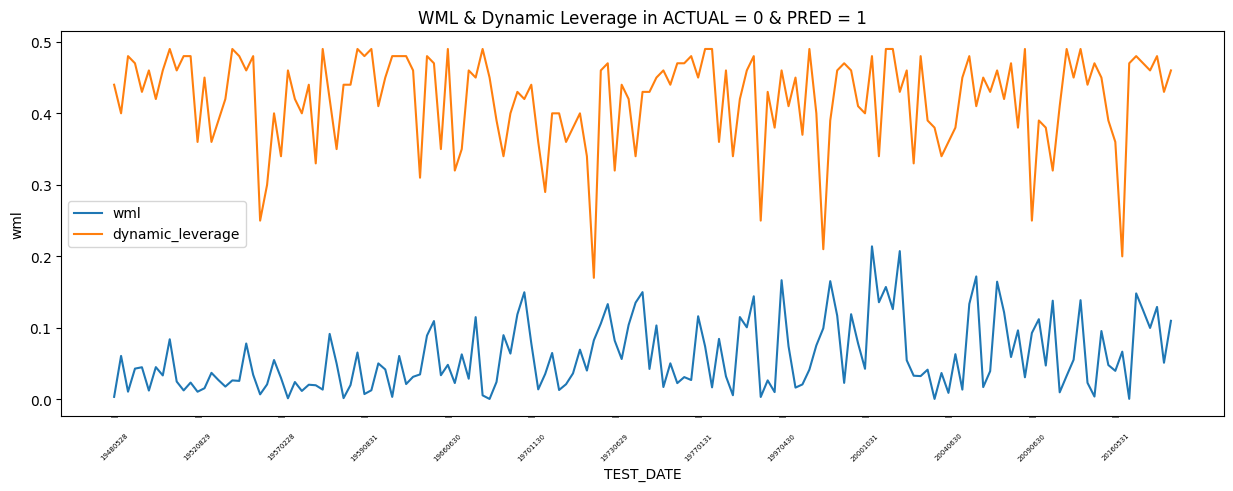

count      mean       var       std       min        1%       25%  \
wml  153.0  0.059858  0.002357  0.048546  0.000627  0.000751  0.021479   

          50%       75%       99%       max  
wml  0.042855  0.092926  0.188946  0.214018

count      mean      var       std   min      1%   25%  \
dynamic_leverage  153.0  0.419608  0.00421  0.064887  0.17  0.2052  0.39   

                   50%   75%   99%   max  
dynamic_leverage  0.44  0.47  0.49  0.49


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



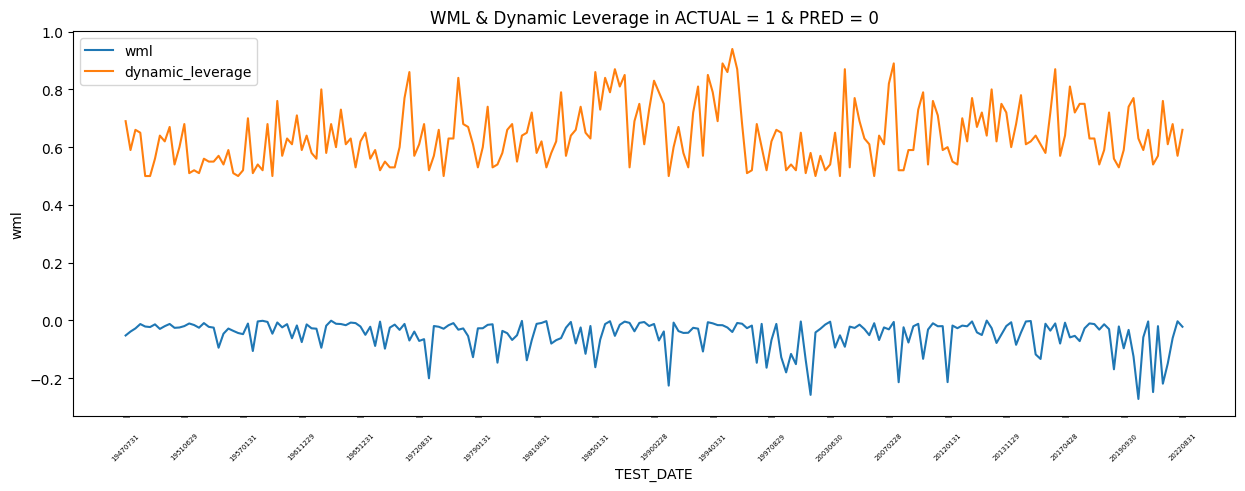

count      mean       var       std       min        1%       25%  \
wml  217.0 -0.047409  0.002826  0.053162 -0.271971 -0.244488 -0.061232   

          50%       75%       99%       max  
wml -0.026761 -0.012856 -0.001346 -0.000506

count      mean       var       std  min   1%   25%   50%  \
dynamic_leverage  217.0  0.640691  0.010555  0.102736  0.5  0.5  0.56  0.62   

                   75%     99%   max  
dynamic_leverage  0.71  0.8868  0.94

In [274]:
plot_predict_result(RDF_TEST)

## Grdient Boosting

In [233]:
GBC_Param = {}
GBC = GradientBoostingClassifier(*GBC_Param, random_state=42)

In [234]:
GBC_TRAIN, GBC_VAL, GBC_TEST = Roling_Windows(data=dynmom, # 사용할 데이터
                                              window_size=120, # window size (훈련 데이터 셋 크기)
                                              validation_size=120, # 검증 데이터 셋 크기
                                              method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                              model=GBC)

**************************************************
설정된 Model의 하이퍼파리미터 : 

   ccp_alpha : 0.0
   criterion : friedman_mse
   init : None
   learning_rate : 0.1
   loss : log_loss
   max_depth : 3
   max_features : None
   max_leaf_nodes : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_iter_no_change : None
   random_state : 42
   subsample : 1.0
   tol : 0.0001
   validation_fraction : 0.1
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]

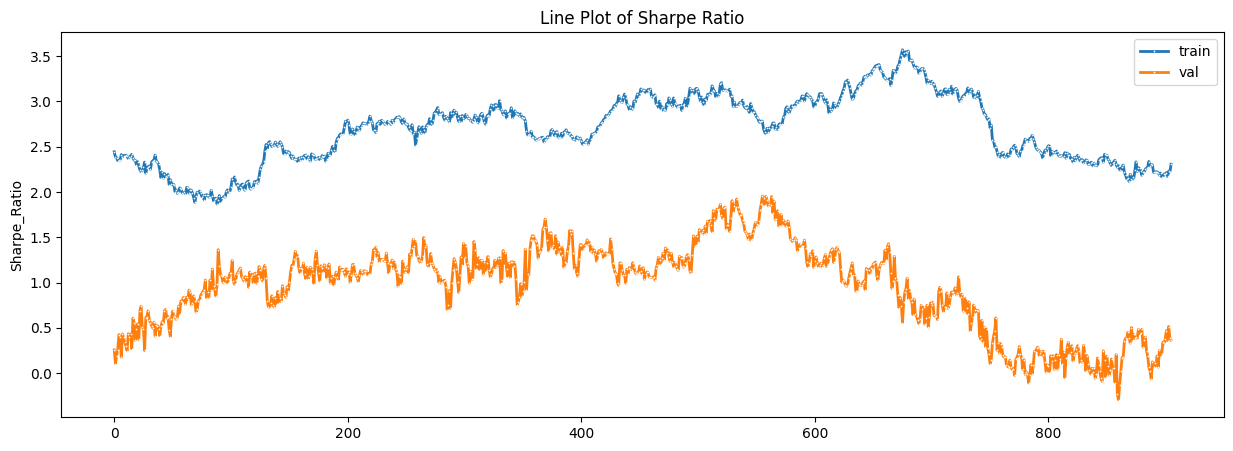

count      mean       var      std       min        1%  \
TRAIN_Sharpe_Ratio  906.0  2.685006  0.139167  0.37305  1.867315  1.936436   

                        25%       50%       75%       99%       max  
TRAIN_Sharpe_Ratio  2.38538  2.720591  2.974757  3.452581  3.569864

count      mean       var       std      min        1%  \
VAL_Sharpe_Ratio  906.0  0.958988  0.226112  0.475513 -0.29281 -0.049076   

                       25%       50%       75%       99%       max  
VAL_Sharpe_Ratio  0.626973  1.078208  1.269783  1.864626  1.955572

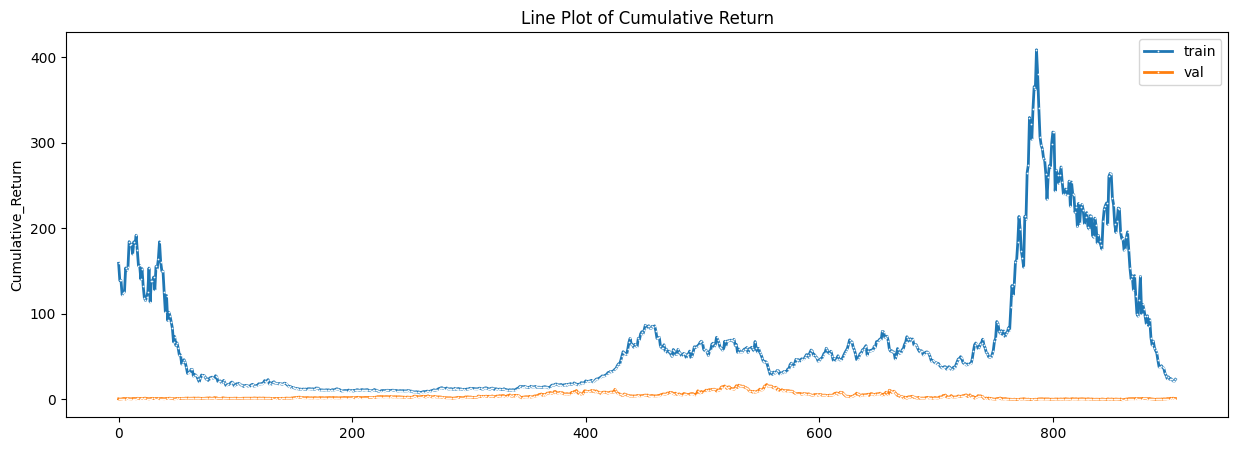

count       mean          var       std       min  \
TRAIN_Cumulative_Return  906.0  64.471682  5055.298233  71.10062  7.326418   

                               1%        25%        50%        75%  \
TRAIN_Cumulative_Return  8.715019  15.127545  45.256329  67.833277   

                                99%         max  
TRAIN_Cumulative_Return  311.492681  408.425334

count      mean        var      std       min  \
VAL_Cumulative_Return  906.0  3.576531  12.804157  3.57829 -0.693014   

                             1%      25%       50%       75%        99%  \
VAL_Cumulative_Return -0.336449  0.94425  2.376467  5.397591  15.255781   

                             max  
VAL_Cumulative_Return  17.090529

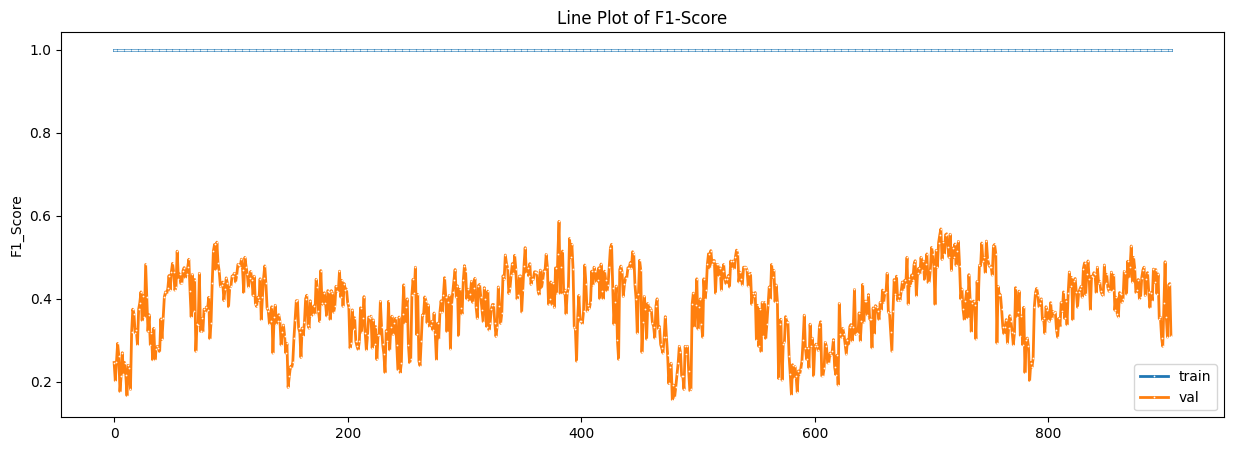

count  mean  var  std  min   1%  25%  50%  75%  99%  max
TRAIN_F1_Score  906.0   1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

count      mean       var       std       min        1%  \
VAL_F1_Score  906.0  0.385429  0.006658  0.081596  0.156863  0.182061   

                   25%       50%       75%      99%       max  
VAL_F1_Score  0.333333  0.395349  0.448276  0.53656  0.586667

In [275]:
train_vs_val(GBC_TRAIN, GBC_VAL)

ORG Sharpe Ratio : 0.7293406994683723
ML Sharpe Ratio : 0.8722209953115941


최근 누적 수익률

  2022년-12월 -> 13264.83
  2022년-11월 -> 12758.55
  2022년-10월 -> 12418.81
  2022년-09월 -> 12095.42
  2022년-08월 -> 11448.34

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 13264.83
  2등 : 2022년-11월 -> 12758.55
  3등 : 2022년-10월 -> 12418.81
  4등 : 2022년-09월 -> 12095.42
  5등 : 2022년-07월 -> 11678.49
  6등 : 2022년-08월 -> 11448.34
  7등 : 2022년-06월 -> 11298.14
  8등 : 2022년-05월 -> 11177.15
  9등 : 2020년-09월 -> 11162.60
  10등 : 2020년-10월 -> 11128.10



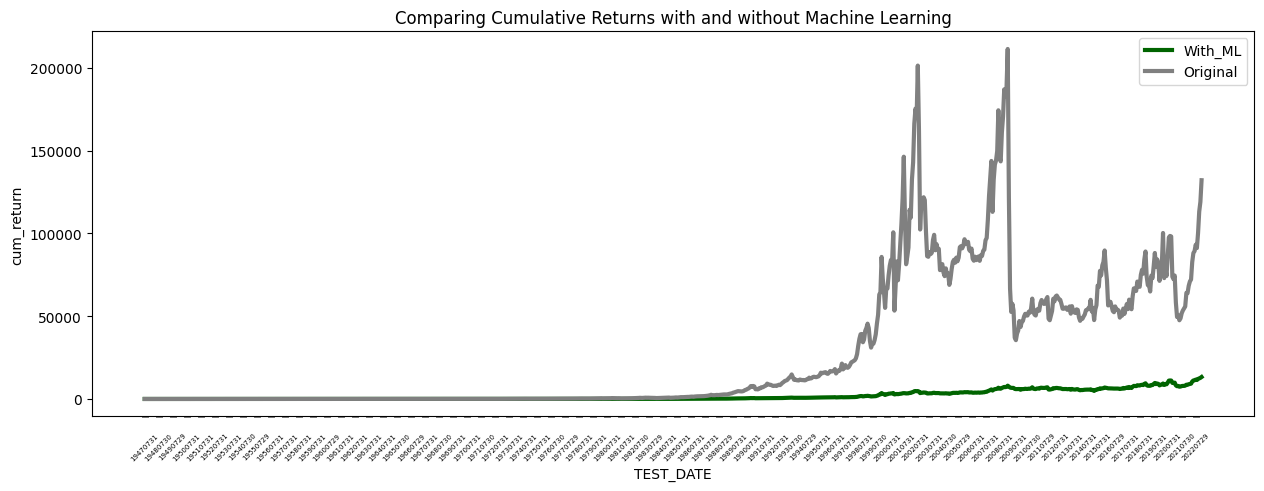

In [276]:
cum_return_sharpe_ratio(GBC_TEST)


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.68      0.67      0.67       590
         1.0       0.39      0.40      0.40       316

    accuracy                           0.58       906
   macro avg       0.54      0.54      0.54       906
weighted avg       0.58      0.58      0.58       906


accuracy : 0.5772626931567328

precision : 0.3949843260188088

recall : 0.3987341772151899

F1-Score : 0.39685039370078745



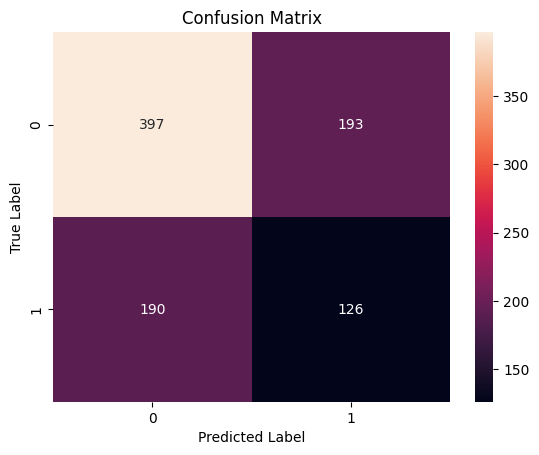


ACTUAL = PRED = 1



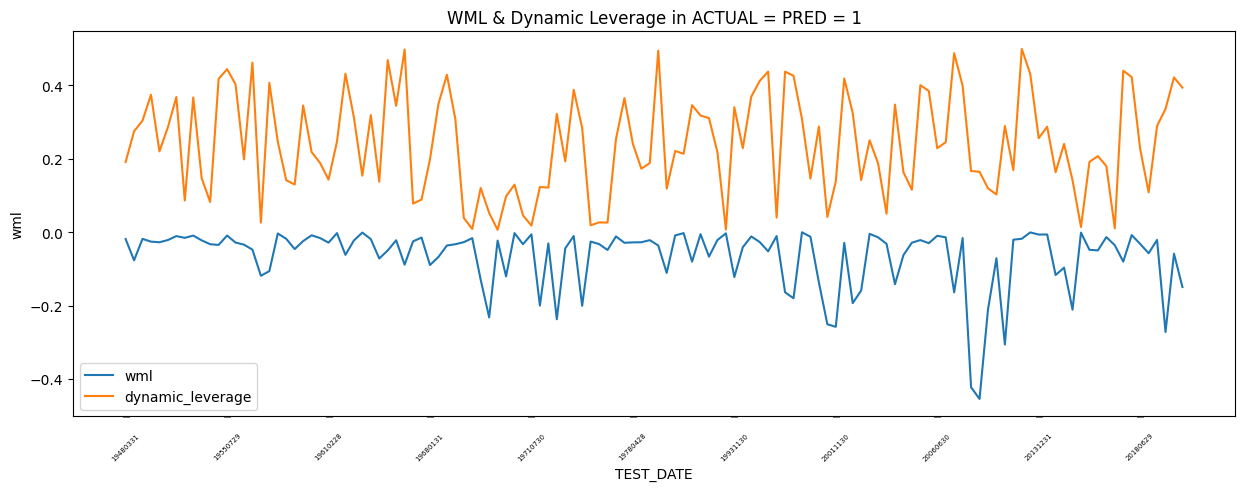

count      mean       var       std       min        1%       25%  \
wml  126.0 -0.065218  0.006909  0.083121 -0.454349 -0.393298 -0.079183   

          50%       75%       99%       max  
wml -0.029393 -0.015809 -0.000619 -0.000132

count      mean      var       std       min        1%  \
dynamic_leverage  126.0  0.241112  0.01887  0.137368  0.006547  0.007718   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.137926  0.228939  0.349092  0.497193  0.499369


--------------------------------------------------------------------------------


ACTUAL = PRED = 0



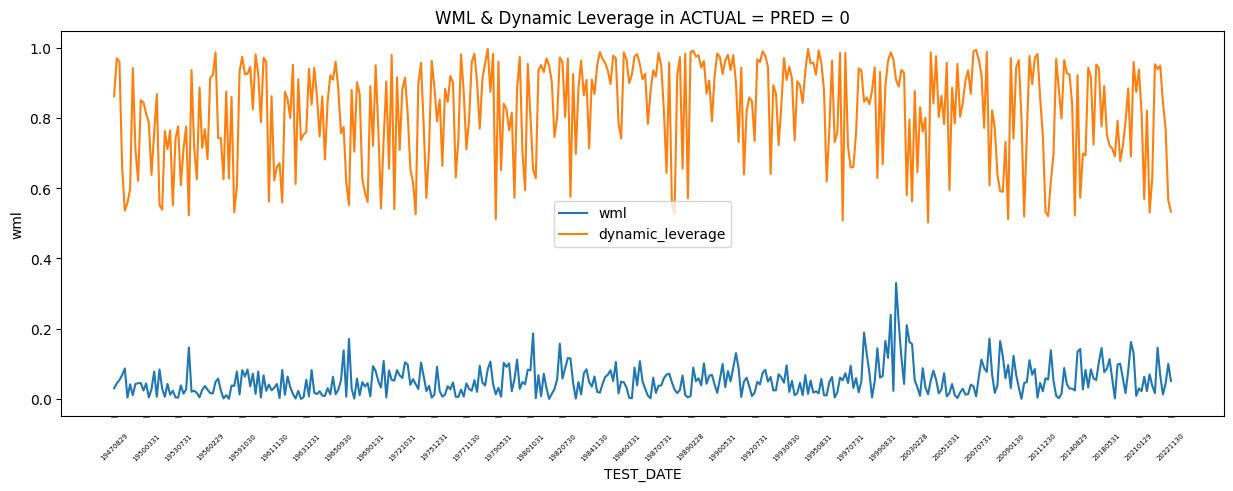

count      mean     var       std       min        1%       25%  \
wml  397.0  0.052129  0.0019  0.043588  0.000128  0.000982  0.018905   

          50%       75%       99%       max  
wml  0.044264  0.071782  0.190063  0.330163

count      mean       var       std       min        1%  \
dynamic_leverage  397.0  0.819408  0.019501  0.139646  0.502119  0.518906   

                       25%       50%       75%       99%      max  
dynamic_leverage  0.720611  0.861805  0.941928  0.991466  0.99604


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



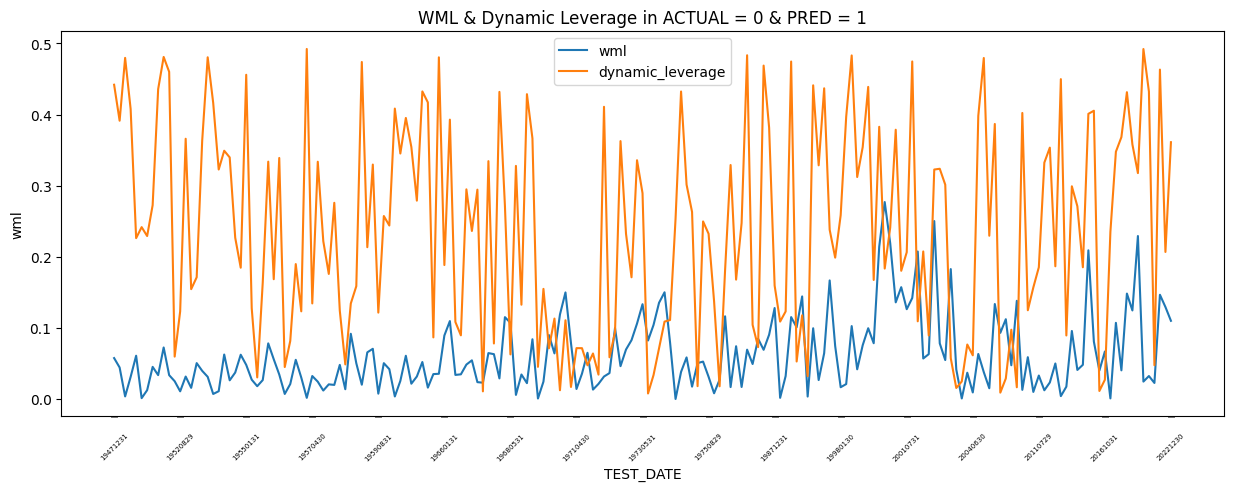

count      mean       var       std       min        1%       25%  \
wml  193.0  0.061669  0.002742  0.052364  0.000007  0.000687  0.024318   

          50%       75%       99%       max  
wml  0.047955  0.083954  0.230814  0.276912

count     mean       var       std       min       1%  \
dynamic_leverage  193.0  0.24069  0.021377  0.146207  0.007755  0.01057   

                       25%       50%       75%       99%      max  
dynamic_leverage  0.110682  0.234861  0.363028  0.484025  0.49217


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



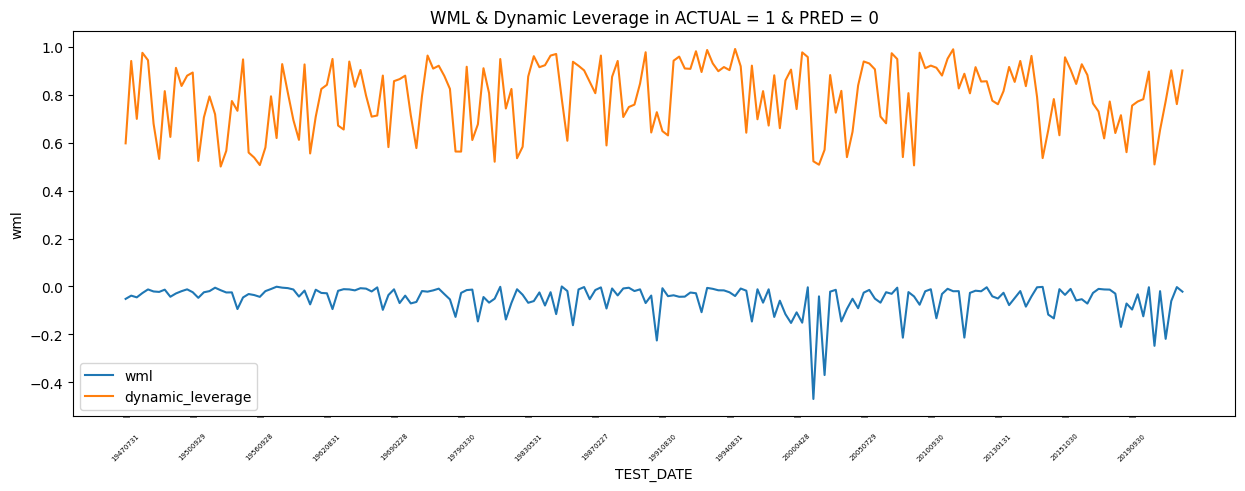

count      mean     var       std       min        1%       25%  \
wml  190.0 -0.050404  0.0038  0.061644 -0.469903 -0.261487 -0.063933   

          50%       75%       99%       max  
wml -0.027502 -0.013893 -0.001602 -0.000183

count      mean       var       std      min        1%  \
dynamic_leverage  190.0  0.791697  0.020048  0.141591  0.50042  0.506426   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.679664  0.820315  0.912862  0.987372  0.991309

In [277]:
plot_predict_result(GBC_TEST)

## XGB

In [238]:
XGB_Param = {}
XGB = XGBClassifier(**XGB_Param, random_state=42)

In [239]:
XGB_TRAIN, XGB_VAL, XGB_TEST = Roling_Windows(data=dynmom, # 사용할 데이터
                                              window_size=120, # window size (훈련 데이터 셋 크기)
                                              validation_size=120, # 검증 데이터 셋 크기
                                              method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                              model=XGB)

**************************************************
설정된 Model의 하이퍼파리미터 : 

   objective : binary:logistic
   use_label_encoder : None
   base_score : None
   booster : None
   callbacks : None
   colsample_bylevel : None
   colsample_bynode : None
   colsample_bytree : None
   early_stopping_rounds : None
   enable_categorical : False
   eval_metric : None
   feature_types : None
   gamma : None
   gpu_id : None
   grow_policy : None
   importance_type : None
   interaction_constraints : None
   learning_rate : None
   max_bin : None
   max_cat_threshold : None
   max_cat_to_onehot : None
   max_delta_step : None
   max_depth : None
   max_leaves : None
   min_child_weight : None
   missing : nan
   monotone_constraints : None
   n_estimators : 100
   n_jobs : None
   num_parallel_tree : None
   predictor : None
   random_state : 42
   reg_alpha : None
   reg_lambda : None
   sampling_method : None
   scale_pos_weight : None
   subsample : None
   tree_method : None
   validate_paramete

  0%|          | 0/906 [00:00<?, ?it/s]

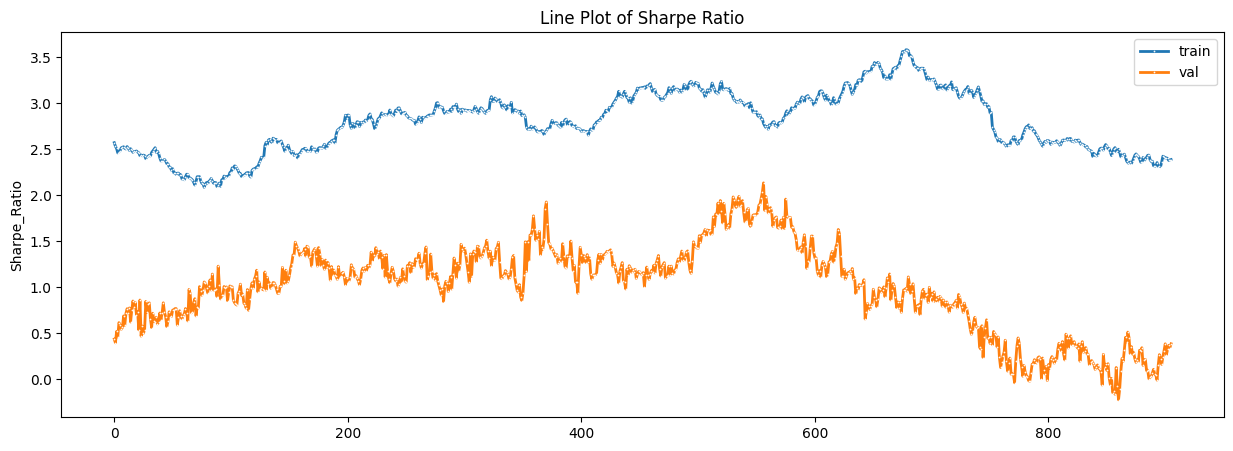

count      mean       var       std       min        1%  \
TRAIN_Sharpe_Ratio  906.0  2.794683  0.109751  0.331288  2.087594  2.131815   

                         25%       50%       75%       99%       max  
TRAIN_Sharpe_Ratio  2.522839  2.815664  3.059502  3.501614  3.582445

count      mean       var       std       min       1%  \
VAL_Sharpe_Ratio  906.0  1.001219  0.223683  0.472951 -0.221861 -0.02045   

                       25%       50%       75%      99%       max  
VAL_Sharpe_Ratio  0.730444  1.086988  1.319864  1.94382  2.135513

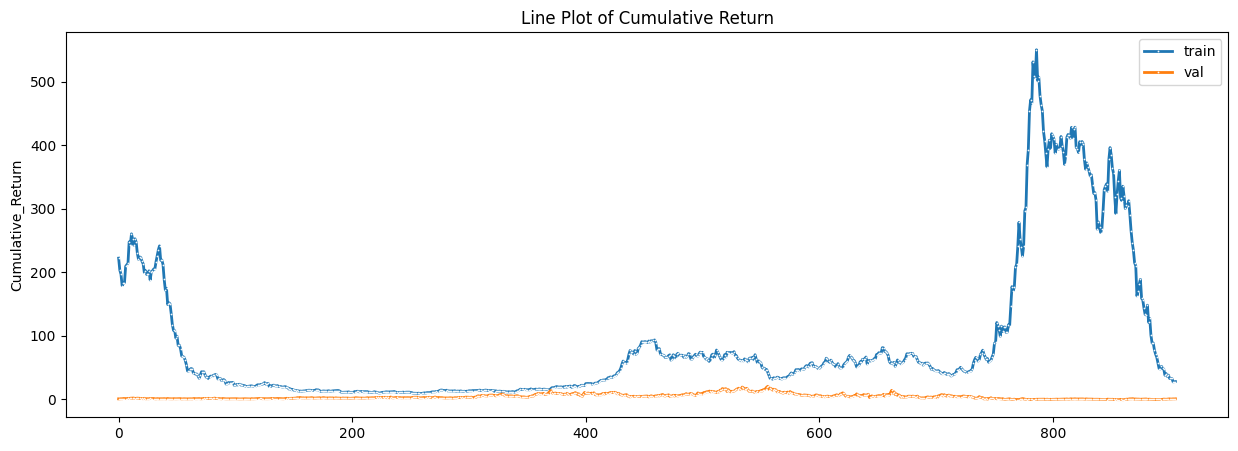

count       mean           var         std      min  \
TRAIN_Cumulative_Return  906.0  87.691707  12496.240629  111.786585  9.19103   

                               1%        25%        50%        75%  \
TRAIN_Cumulative_Return  9.795672  18.346516  48.524886  73.779726   

                                99%         max  
TRAIN_Cumulative_Return  463.268591  550.303742

count      mean        var       std       min  \
VAL_Cumulative_Return  906.0  4.336092  16.638623  4.079047 -0.636037   

                             1%       25%       50%       75%        99%  \
VAL_Cumulative_Return -0.269551  1.051278  2.905703  6.473767  16.833398   

                             max  
VAL_Cumulative_Return  20.608169

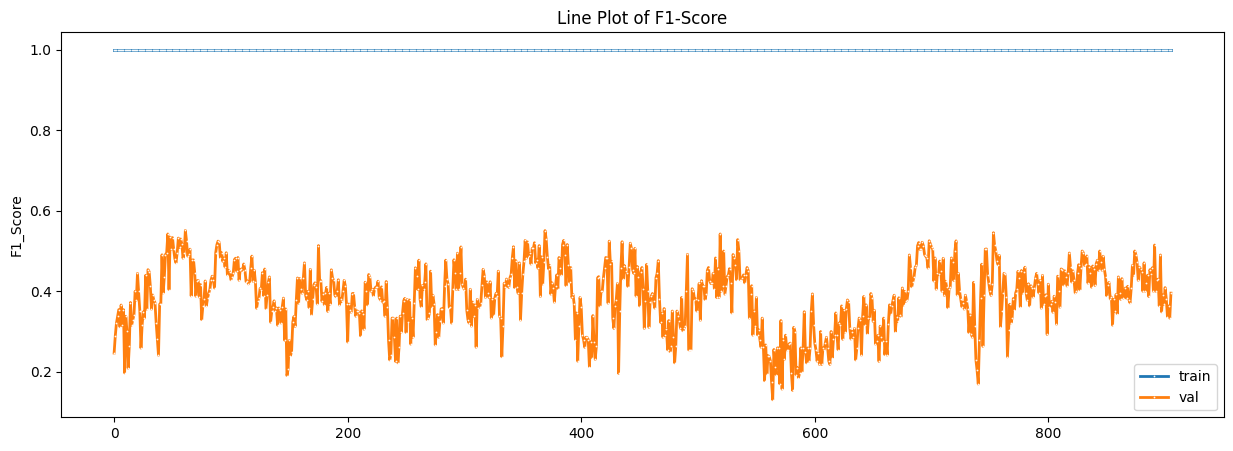

count  mean  var  std  min   1%  25%  50%  75%  99%  max
TRAIN_F1_Score  906.0   1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

count      mean       var       std       min        1%  \
VAL_F1_Score  906.0  0.384813  0.006335  0.079594  0.130435  0.192308   

                   25%       50%       75%       99%       max  
VAL_F1_Score  0.336901  0.392157  0.442044  0.529356  0.551181

In [278]:
train_vs_val(XGB_TRAIN, XGB_VAL)

ORG Sharpe Ratio : 0.7293406994683723
ML Sharpe Ratio : 0.7780757206313932


최근 누적 수익률

  2022년-12월 -> 20448.37
  2022년-11월 -> 19990.26
  2022년-10월 -> 19608.46
  2022년-09월 -> 19441.92
  2022년-08월 -> 18768.75

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 23709.19
  2등 : 2008년-06월 -> 21843.47
  3등 : 2009년-01월 -> 21454.52
  4등 : 2008년-11월 -> 21323.91
  5등 : 2008년-12월 -> 20878.54
  6등 : 2008년-10월 -> 20730.47
  7등 : 2022년-12월 -> 20448.37
  8등 : 2008년-09월 -> 20086.25
  9등 : 2002년-09월 -> 20006.72
  10등 : 2022년-11월 -> 19990.26



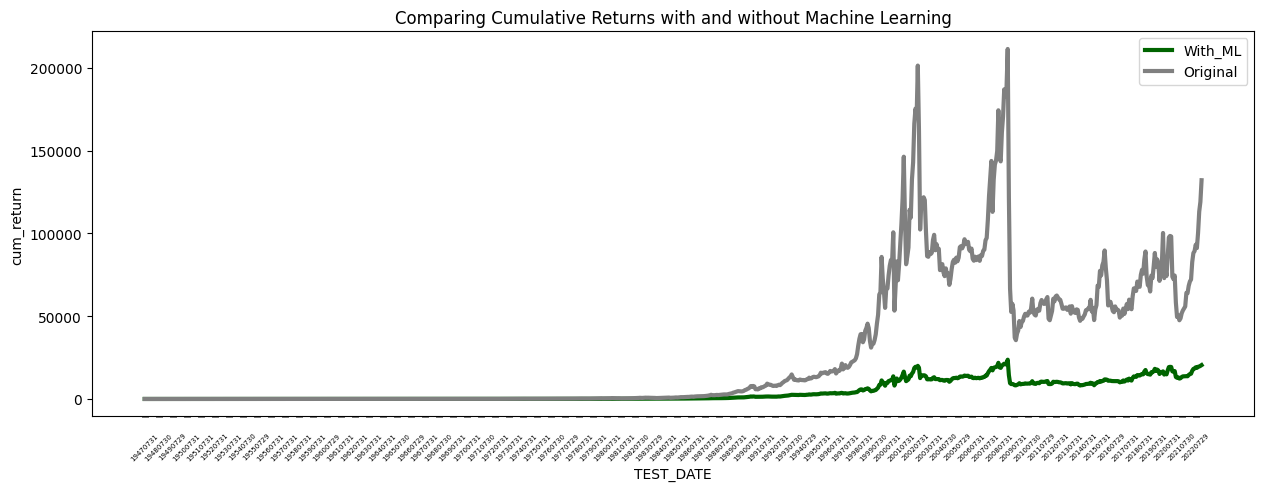

In [279]:
cum_return_sharpe_ratio(XGB_TEST)


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.69      0.72      0.70       590
         1.0       0.42      0.39      0.40       316

    accuracy                           0.60       906
   macro avg       0.55      0.55      0.55       906
weighted avg       0.59      0.60      0.60       906


accuracy : 0.6026490066225165

precision : 0.4236111111111111

recall : 0.3860759493670886

F1-Score : 0.4039735099337748



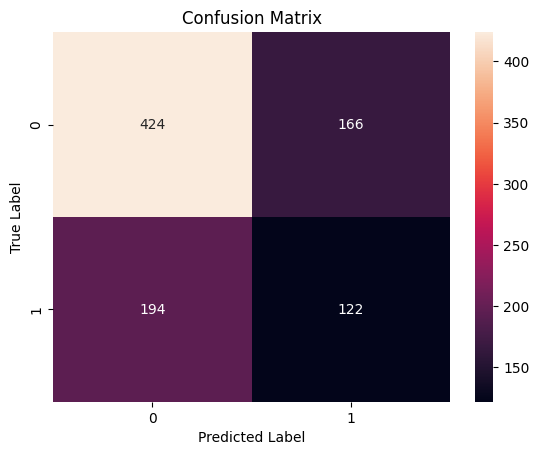


ACTUAL = PRED = 1



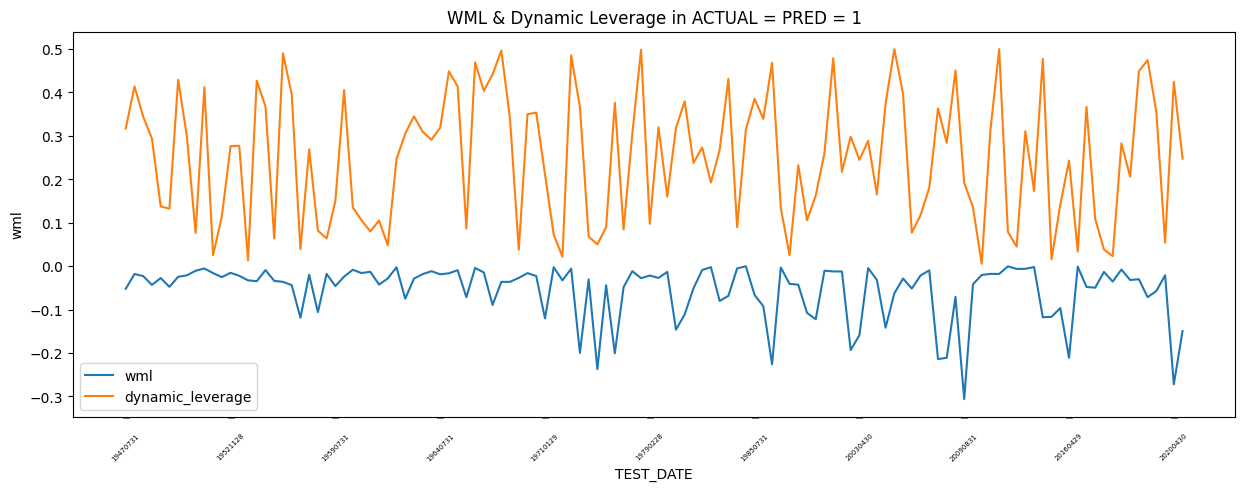

count      mean       var       std      min        1%       25%  \
wml  122.0 -0.054575  0.004053  0.063661 -0.30599 -0.264647 -0.067862   

          50%       75%       99%       max  
wml -0.029378 -0.014708 -0.000625 -0.000183

count      mean       var      std       min        1%  \
dynamic_leverage  122.0  0.249187  0.022168  0.14889  0.005504  0.013982   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.105455  0.271128  0.367389  0.499257  0.499883


--------------------------------------------------------------------------------


ACTUAL = PRED = 0



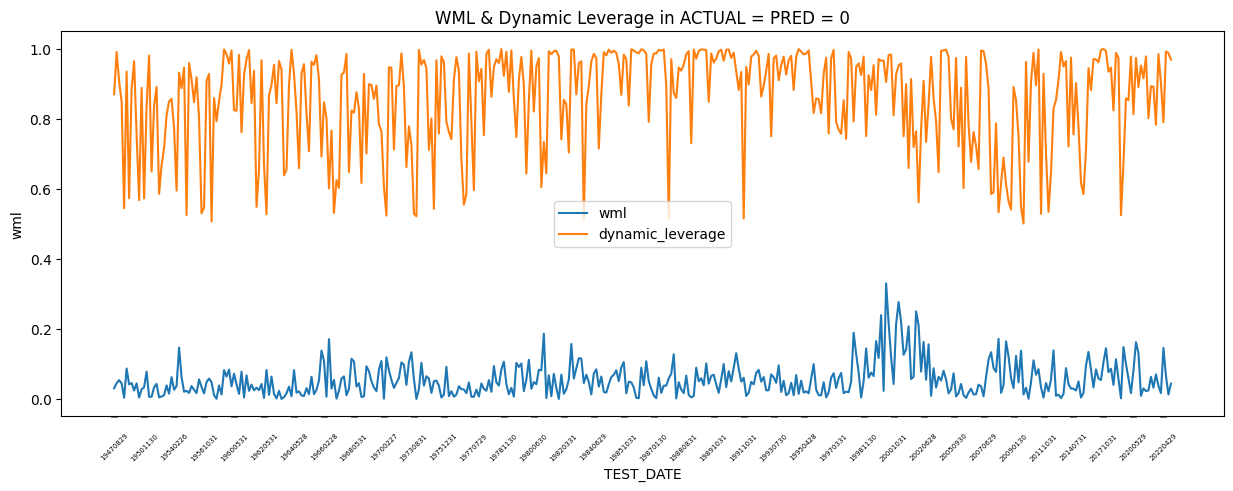

count      mean       var       std       min        1%       25%  \
wml  424.0  0.055391  0.002319  0.048153  0.000007  0.000632  0.019945   

          50%      75%       99%       max  
wml  0.044985  0.07582  0.218522  0.330163

count      mean       var       std       min        1%  \
dynamic_leverage  424.0  0.858128  0.019543  0.139796  0.501142  0.517545   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.773087  0.902408  0.974141  0.998747  0.999726


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



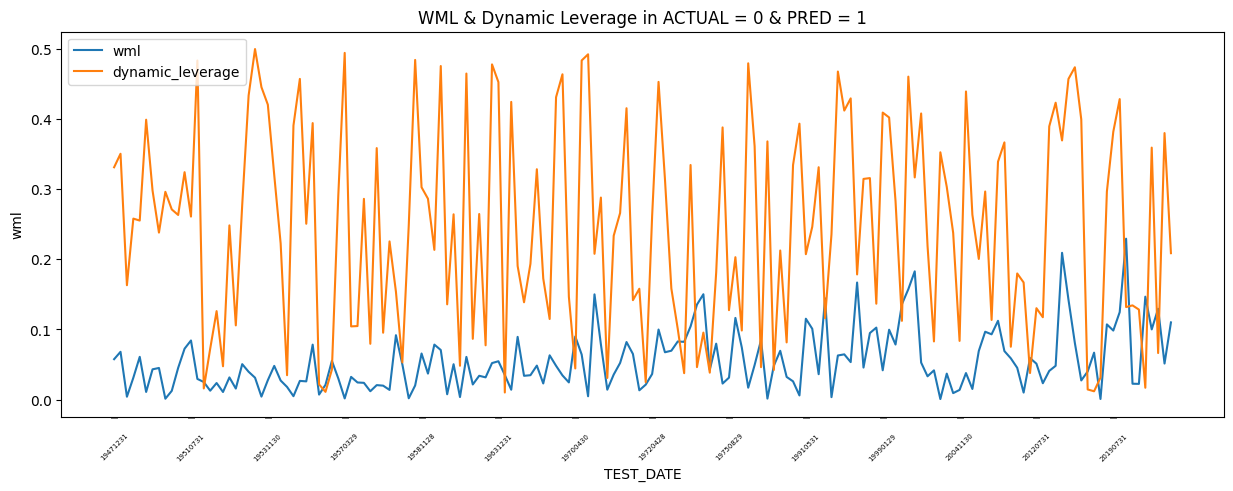

count      mean       var       std       min       1%       25%  \
wml  166.0  0.054888  0.001878  0.043332  0.000692  0.00104  0.023302   

          50%       75%       99%      max  
wml  0.045171  0.078242  0.191883  0.22913

count      mean       var       std       min        1%  \
dynamic_leverage  166.0  0.246797  0.021078  0.145183  0.010033  0.011483   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.116313  0.252701  0.368785  0.492521  0.499298


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



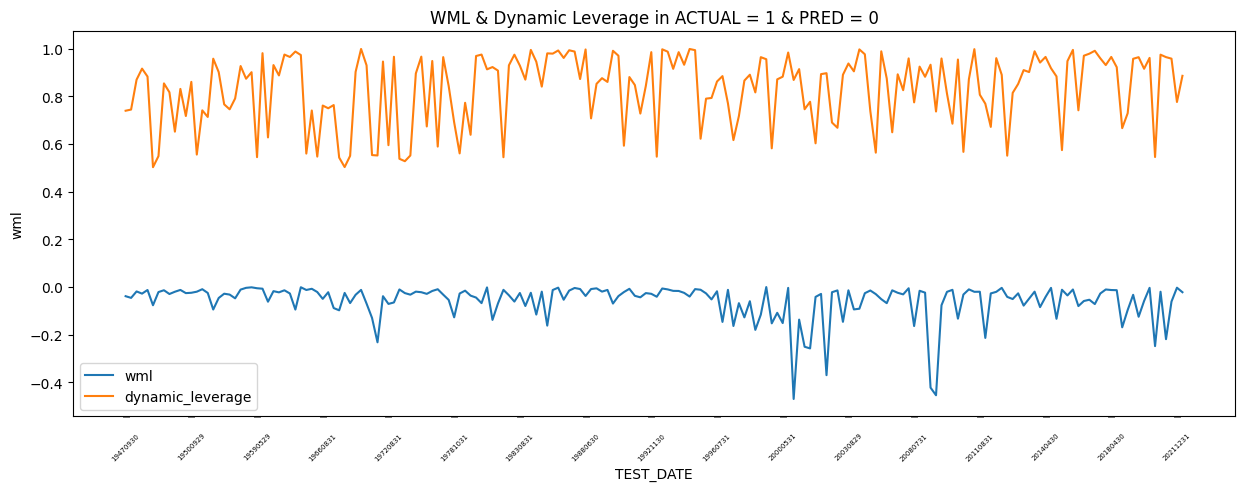

count      mean       var       std       min        1%      25%  \
wml  194.0 -0.057402  0.005738  0.075751 -0.469903 -0.424637 -0.06784   

          50%       75%       99%       max  
wml -0.028323 -0.014757 -0.001267 -0.000132

count      mean      var       std      min       1%  \
dynamic_leverage  194.0  0.831771  0.02151  0.146664  0.50288  0.52628   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.740092  0.882542  0.958953  0.998307  0.999078

In [280]:
plot_predict_result(XGB_TEST)

## LGBM

In [243]:
LGBM_param = {}
LGBM = LGBMClassifier(**LGBM_param, random_state=42)

In [244]:
LGBM_TRAIN, LGBM_VAL, LGBM_TEST = Roling_Windows(data=dynmom, # 사용할 데이터
                                                  window_size=120, # window size (훈련 데이터 셋 크기)
                                                  validation_size=120, # 검증 데이터 셋 크기
                                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                                  model=LGBM)

**************************************************
설정된 Model의 하이퍼파리미터 : 

   boosting_type : gbdt
   class_weight : None
   colsample_bytree : 1.0
   importance_type : split
   learning_rate : 0.1
   max_depth : -1
   min_child_samples : 20
   min_child_weight : 0.001
   min_split_gain : 0.0
   n_estimators : 100
   n_jobs : -1
   num_leaves : 31
   objective : None
   random_state : 42
   reg_alpha : 0.0
   reg_lambda : 0.0
   silent : warn
   subsample : 1.0
   subsample_for_bin : 200000
   subsample_freq : 0

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]

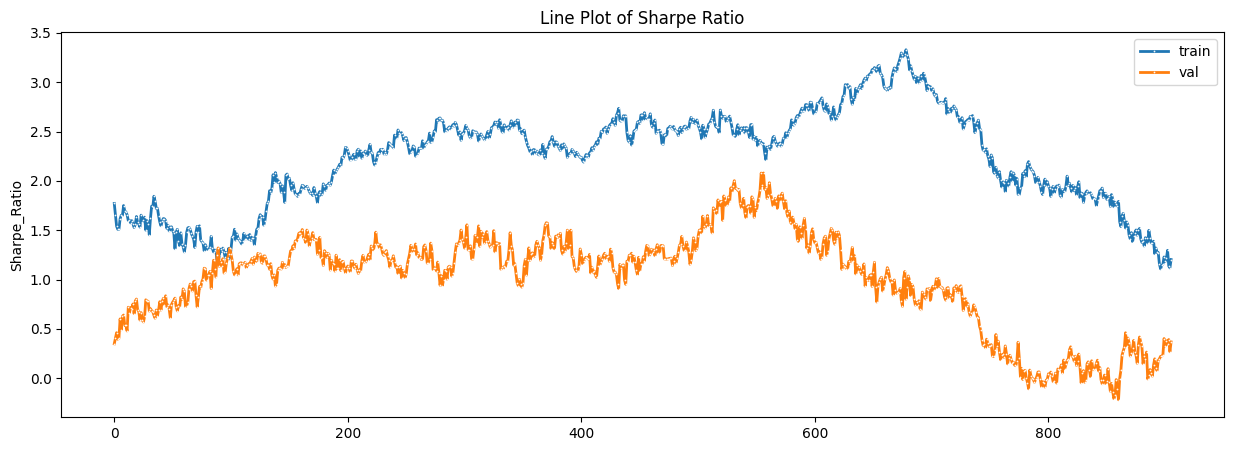

count      mean       var       std       min        1%  \
TRAIN_Sharpe_Ratio  906.0  2.231501  0.244176  0.494142  1.108224  1.202732   

                         25%       50%       75%       99%      max  
TRAIN_Sharpe_Ratio  1.876886  2.337817  2.569334  3.170643  3.32865

count      mean       var       std       min        1%  \
VAL_Sharpe_Ratio  906.0  1.003477  0.242443  0.492385 -0.218909 -0.057045   

                       25%       50%       75%       99%       max  
VAL_Sharpe_Ratio  0.745376  1.129693  1.313541  1.920895  2.079614

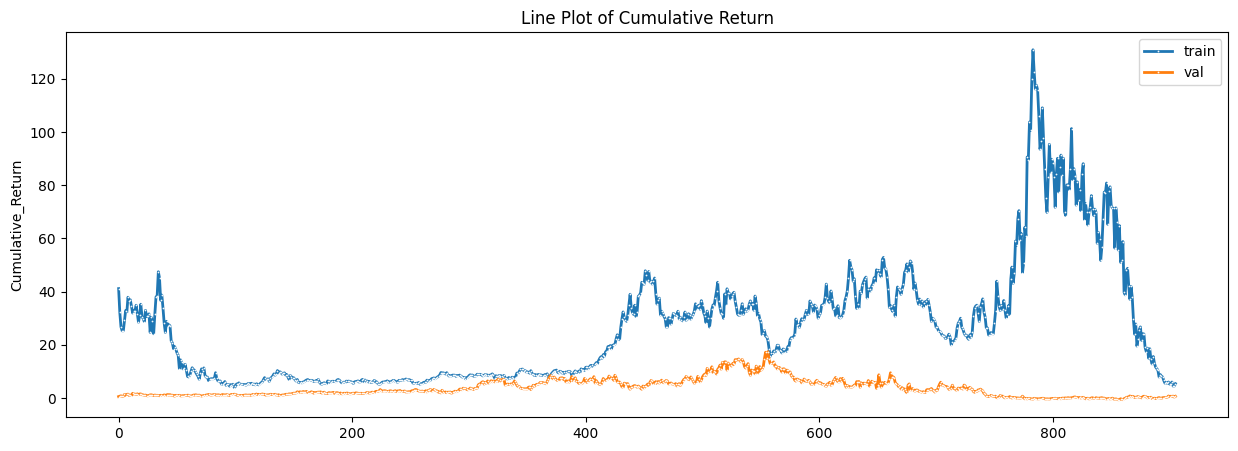

count      mean         var        std       min  \
TRAIN_Cumulative_Return  906.0  26.64428  504.436846  22.459672  3.952788   

                               1%       25%        50%        75%        99%  \
TRAIN_Cumulative_Return  4.991353  8.256963  23.550475  35.444848  101.25185   

                               max  
TRAIN_Cumulative_Return  130.89532

count      mean       var       std       min  \
VAL_Cumulative_Return  906.0  3.758149  11.51219  3.392962 -0.610787   

                             1%       25%       50%       75%        99%  \
VAL_Cumulative_Return -0.314135  1.123202  2.753092  5.830271  14.220179   

                             max  
VAL_Cumulative_Return  17.484111

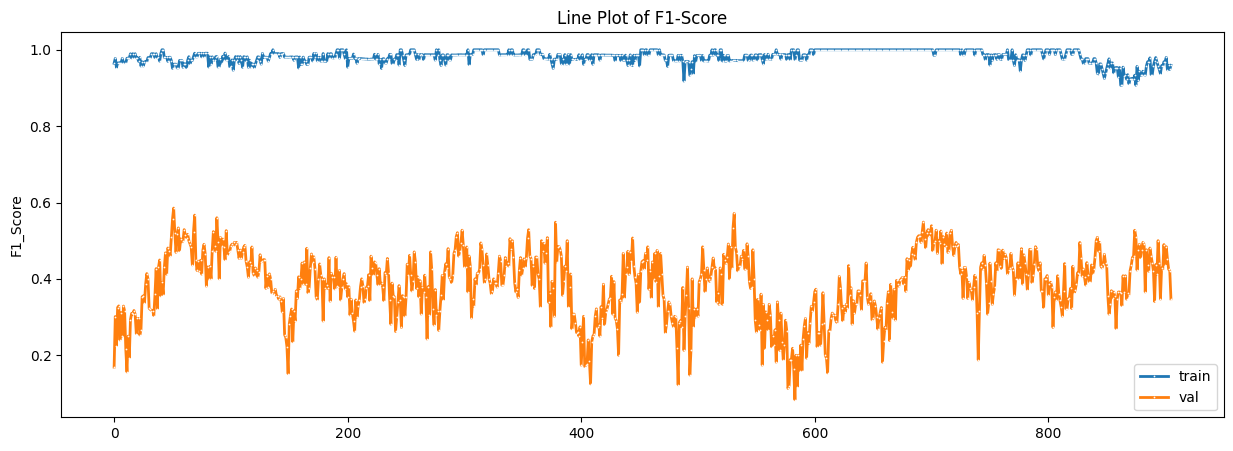

count      mean       var       std       min        1%  \
TRAIN_F1_Score  906.0  0.981702  0.000285  0.016884  0.906977  0.924731   

                     25%       50%  75%  99%  max  
TRAIN_F1_Score  0.972973  0.985915  1.0  1.0  1.0

count      mean       var       std       min        1%  \
VAL_F1_Score  906.0  0.384248  0.007261  0.085214  0.083333  0.156438   

                  25%       50%       75%       99%       max  
VAL_F1_Score  0.32931  0.394737  0.445822  0.533113  0.585366

In [281]:
train_vs_val(LGBM_TRAIN, LGBM_VAL)

ORG Sharpe Ratio : 0.7293406994683723
ML Sharpe Ratio : 0.8151839881409202


최근 누적 수익률

  2022년-12월 -> 11974.29
  2022년-11월 -> 11600.38
  2022년-10월 -> 11448.11
  2022년-09월 -> 10871.33
  2022년-08월 -> 10569.52

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 13443.03
  2등 : 2002년-09월 -> 13024.56
  3등 : 2002년-07월 -> 12834.23
  4등 : 2007년-12월 -> 12800.38
  5등 : 2002년-08월 -> 12642.45
  6등 : 2002년-10월 -> 12583.85
  7등 : 2002년-06월 -> 12532.03
  8등 : 2008년-06월 -> 12491.78
  9등 : 2019년-08월 -> 12427.87
  10등 : 2018년-12월 -> 12376.76



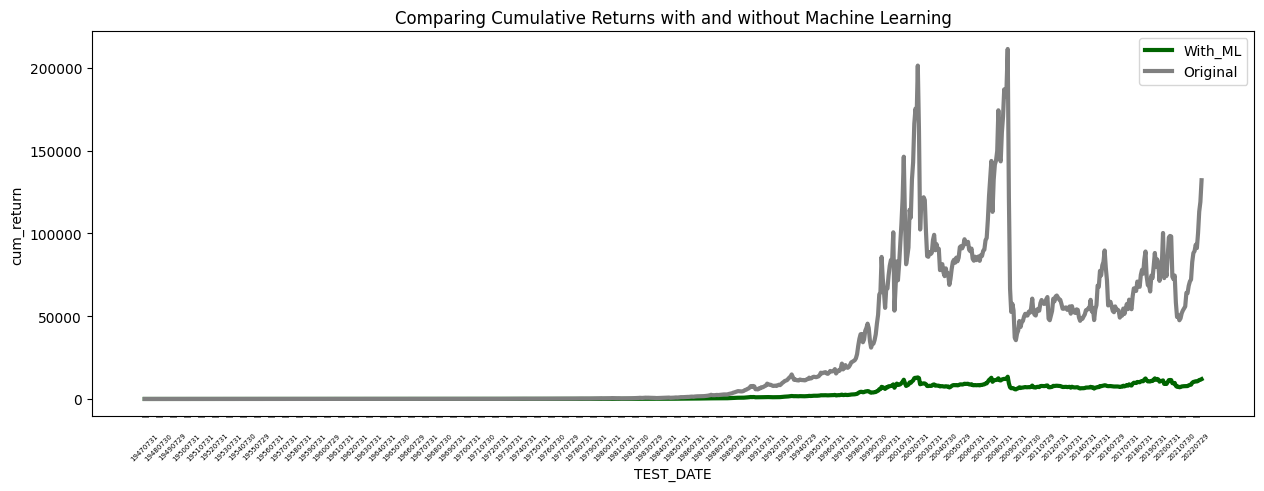

In [282]:
cum_return_sharpe_ratio(LGBM_TEST)


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.68      0.72      0.70       590
         1.0       0.40      0.36      0.38       316

    accuracy                           0.59       906
   macro avg       0.54      0.54      0.54       906
weighted avg       0.58      0.59      0.59       906


accuracy : 0.5916114790286976

precision : 0.40425531914893614

recall : 0.36075949367088606

F1-Score : 0.3812709030100334



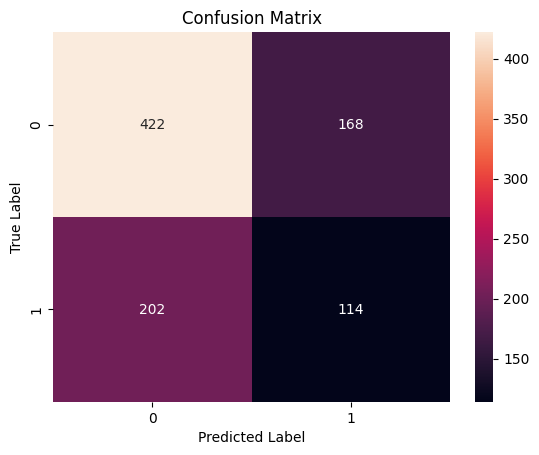


ACTUAL = PRED = 1



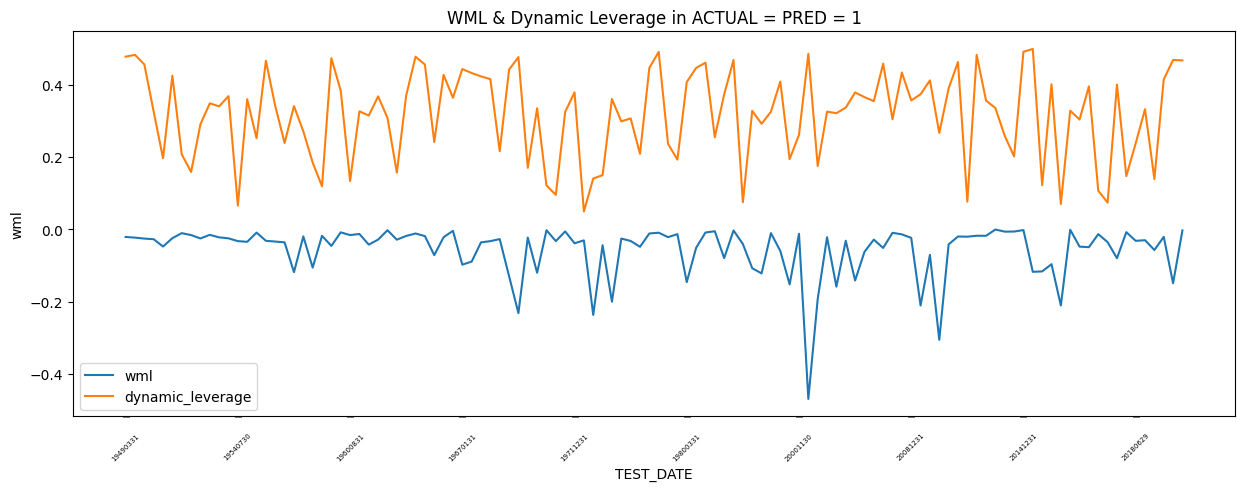

count      mean       var       std       min        1%       25%  \
wml  114.0 -0.056068  0.005076  0.071249 -0.469903 -0.297033 -0.061742   

          50%       75%       99%       max  
wml -0.029378 -0.015905 -0.001199 -0.000506

count      mean       var       std       min        1%  \
dynamic_leverage  114.0  0.318701  0.015017  0.122543  0.049379  0.066294   

                       25%       50%       75%       99%      max  
dynamic_leverage  0.237003  0.336573  0.415873  0.491909  0.49963


--------------------------------------------------------------------------------


ACTUAL = PRED = 0



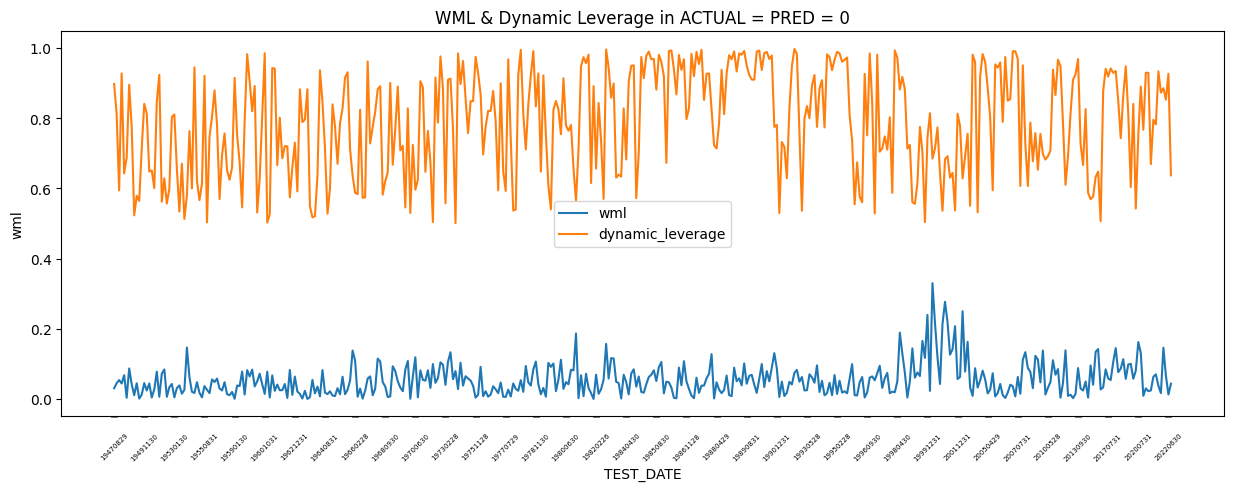

count      mean      var       std       min        1%       25%  \
wml  422.0  0.054647  0.00216  0.046476  0.000128  0.001032  0.020074   

          50%       75%       99%       max  
wml  0.046155  0.076363  0.218565  0.330163

count      mean       var       std       min        1%  \
dynamic_leverage  422.0  0.787826  0.021576  0.146889  0.501009  0.504738   

                      25%       50%       75%       99%       max  
dynamic_leverage  0.66187  0.801718  0.923942  0.993068  0.997291


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



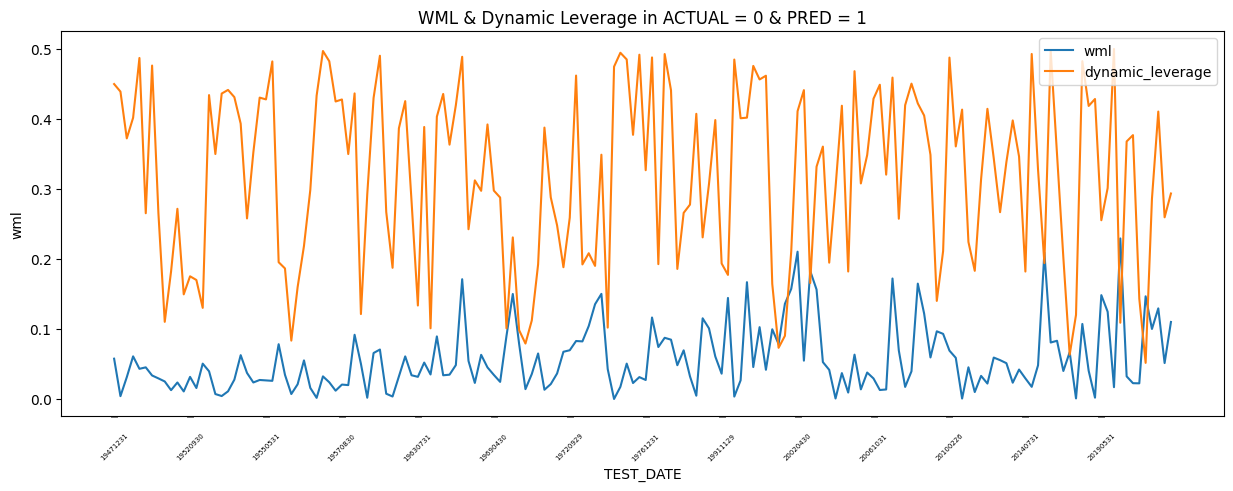

count      mean      var       std       min        1%       25%  \
wml  168.0  0.056764  0.00228  0.047748  0.000007  0.000654  0.023462   

          50%       75%       99%      max  
wml  0.041847  0.078245  0.209426  0.22913

count      mean       var       std       min        1%  \
dynamic_leverage  168.0  0.318109  0.015659  0.125136  0.051522  0.069776   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.200059  0.340924  0.427723  0.496693  0.499559


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



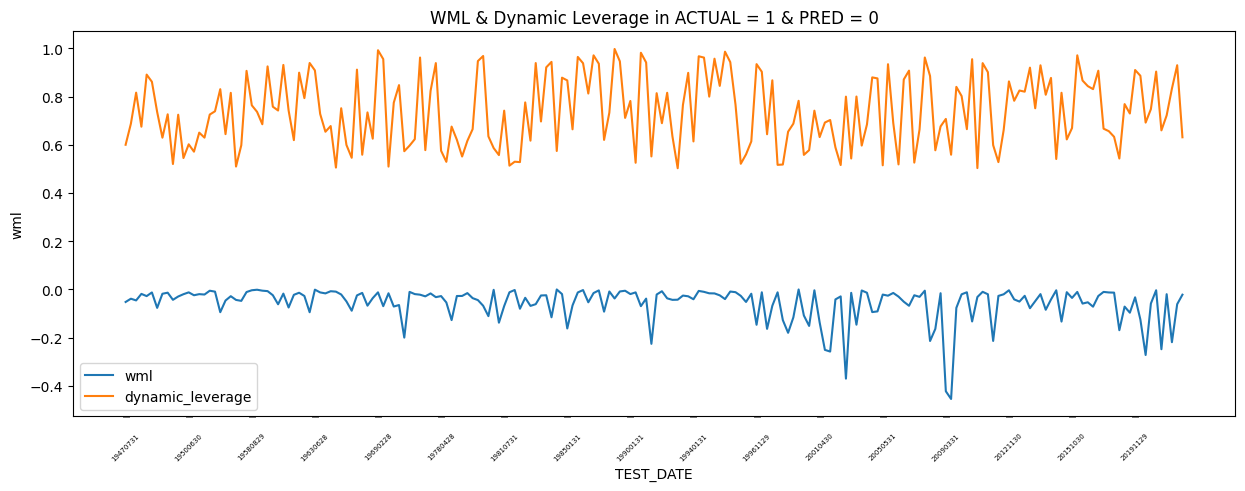

count      mean       var       std       min       1%       25%  \
wml  202.0 -0.056448  0.005099  0.071404 -0.454349 -0.36906 -0.068209   

          50%       75%       99%       max  
wml -0.028323 -0.014281 -0.000961 -0.000132

count     mean       var      std       min       1%  \
dynamic_leverage  202.0  0.73926  0.021524  0.14671  0.502593  0.50532   

                      25%       50%       75%       99%       max  
dynamic_leverage  0.61748  0.733465  0.876663  0.985909  0.997184

In [283]:
plot_predict_result(LGBM_TEST)